In [4]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import PIL

In [5]:
def regrid(dataset, variable_name):
    
    new_lon = np.arange(-127.45, -112.55, 0.1)
    new_lat = np.arange(32.05, 45.95, 0.1)

    # Create meshgrid for new coordinates
    new_lon_grid, new_lat_grid = np.meshgrid(new_lon, new_lat)

    # Initialize an empty array for the regridded dataset
    regridded_variable = np.zeros((len(dataset['time']), len(new_lat), len(new_lon)))

    # Interpolate each time step separately
    for i, time_step in enumerate(dataset['time']):
        # Get original longitude and latitude meshgrid
        original_lon, original_lat = np.meshgrid(dataset['lon'], dataset['lat'])
        original_points = np.array([original_lon.flatten(), original_lat.flatten()]).T

        # Get original values and flatten them
        original_values = dataset[variable_name][i, :, :].values.flatten()

        # Perform interpolation using griddata
        regridded_variable[i, :, :] = griddata(original_points, original_values, (new_lon_grid, new_lat_grid), method='linear')

    # Create a new xarray Dataset for the regridded data
    new_dataset = xr.Dataset({
        variable_name: (['time', 'lat', 'lon'], regridded_variable),
    }, coords={'time': dataset['time'], 'lat': new_lat, 'lon': new_lon})

    return new_dataset

In [3]:
GFS = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/CA_GFS_0p25_f000_2017-2023.nc")
GFS

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 10224, lat: 57, lon: 65)
Coordinates:
  * time     (time) datetime64[ns] 82kB 2016-12-31T12:00:00 ... 2023-12-31T06...
  * lat      (lat) float32 228B 46.0 45.75 45.5 45.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 260B 232.0 232.2 232.5 232.8 ... 247.5 247.8 248.0
Data variables: (12/14)
    pwv      (time, lat, lon) float32 152MB ...
    cw       (time, lat, lon) float32 152MB ...
    tk2      (time, lat, lon) float32 152MB ...
    qv2      (time, lat, lon) float32 152MB ...
    u10      (time, lat, lon) float32 152MB ...
    v10      (time, lat, lon) float32 152MB ...
    ...       ...
    ps       (time, lat, lon) float32 152MB ...
    pr       (time, lat, lon) float32 152MB ...
    cfr      (time, lat, lon) float32 152MB ...
    dbz      (time, lat, lon) float32 152MB ...
    u700     (time, lat, lon) float32 152MB ...
    v700     (time, lat, lon) float32 152MB ...

In [4]:
# Adjust longitudes to be within [-180, 180]
longitudes = GFS['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS = GFS.assign_coords(lon=adjusted_longitudes)

In [85]:
GFS_empty_days_filled = GFS.interpolate_na(dim='time', method='linear')
GFS_empty_days_filled

-123.5

In [8]:
output_dir = '/Users/nathanchen/Documents/JIFRESSE/data_2/'  # Replace with your desired output directory

for var_name in GFS_empty_days_filled.data_vars:
    # Create a new dataset with only the current variable and its coordinates
    single_var_data = GFS_empty_days_filled[[var_name]]
    
    # Add relevant coordinates to the new dataset
    for coord in GFS_empty_days_filled.coords:
        if coord not in single_var_data.coords:
            single_var_data = single_var_data.assign_coords({coord: GFS_empty_days_filled.coords[coord]})
    
    # Define the output file path
    output_file_path = f"{output_dir}GFS_{var_name}.nc"
    
    # Save the new dataset to a NetCDF file
    single_var_data.to_netcdf(output_file_path)
    
    print(f"Variable '{var_name}' saved to {output_file_path}")

print("All variables have been saved to separate files.")

Variable 'pwv' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_pwv.nc
Variable 'cw' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_cw.nc
Variable 'tk2' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_tk2.nc
Variable 'qv2' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_qv2.nc
Variable 'u10' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_u10.nc
Variable 'v10' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_v10.nc
Variable 'cape' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_cape.nc
Variable 'cin' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_cin.nc
Variable 'ps' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_ps.nc
Variable 'pr' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_pr.nc
Variable 'cfr' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_cfr.nc
Variable 'dbz' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_dbz.nc
Variable 'u700' saved to /Users/nathanchen/Documents/JIF

In [11]:
pwv00 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_pwv.nc")
pwv00_regrid = regrid(pwv00, 'pwv')
pwv00_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_pwv00_regrid.nc")


In [37]:
cape00 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_cape.nc")
cape00_regrid = regrid(cape00, 'cape')
cape00_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_cape00_regrid.nc")

In [38]:
cfr00 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_cfr.nc")
cfr00_regrid = regrid(cfr00, 'cfr')
cfr00_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_cfr00_regrid.nc")


In [39]:
cin00 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_cin.nc")
cin00_regrid = regrid(cin00, 'cin')
cin00_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_cin00_regrid.nc")

In [40]:
dbz00 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_dbz.nc")
dbz00_regrid = regrid(dbz00, 'dbz')
dbz00_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_dbz00_regrid.nc")

In [41]:
pr00 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_pr.nc")
pr00_regrid = regrid(pr00, 'pr')
pr00_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_pr00_regrid.nc")

In [42]:
ps00 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_ps.nc")
ps00_regrid = regrid(ps00, 'ps')
ps00_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_ps00_regrid.nc")

In [43]:
qv200 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_qv2.nc")
qv200_regrid = regrid(qv200, 'qv2')
qv200_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_qv200_regrid.nc")

In [44]:
tk200 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_tk2.nc")
tk200_regrid = regrid(tk200, 'tk2')
tk200_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_tk200_regrid.nc")

In [45]:
u1000 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_u10.nc")
u1000_regrid = regrid(u1000, 'u10')
u1000_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_u1000_regrid.nc")

In [46]:
v1000 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_v10.nc")
v1000_regrid = regrid(v1000, 'v10')
v1000_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_v1000_regrid.nc")

In [47]:
u70000 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_u700.nc")
u70000_regrid = regrid(u70000, 'u700')
u70000_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_u70000_regrid.nc")

In [48]:
v70000 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_v700.nc")
v70000_regrid = regrid(v70000, 'v700')
v70000_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_v70000_regrid.nc")

In [ ]:
GFS_12 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/CA_GFS_0p25_f012_2017-2023.nc")
GFS_12

In [ ]:
longitudes = GFS_12['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_12 = GFS_12.assign_coords(lon=adjusted_longitudes)
GFS_12

In [22]:
GFS_12

GFS_12_empty_days_filled = GFS_12.interpolate_na(dim='time', method='linear')
GFS_12_empty_days_filled

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 10224, lat: 57, lon: 65)
Coordinates:
  * time     (time) datetime64[ns] 82kB 2016-12-31T12:00:00 ... 2023-12-31T06...
  * lat      (lat) float32 228B 46.0 45.75 45.5 45.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 260B -128.0 -127.8 -127.5 ... -112.5 -112.2 -112.0
Data variables: (12/14)
    pwv      (time, lat, lon) float32 152MB 7.4 7.6 7.7 ... 8.243 8.629 8.488
    cw       (time, lat, lon) float32 152MB nan nan nan nan ... nan nan nan nan
    tk2      (time, lat, lon) float32 152MB 280.9 280.9 281.0 ... 287.0 287.0
    qv2      (time, lat, lon) float32 152MB 0.00436 0.0044 ... 0.004655 0.00422
    u10      (time, lat, lon) float32 152MB 8.17 8.41 8.67 ... -0.6002 0.3098
    v10      (time, lat, lon) float32 152MB -12.64 -12.49 ... 0.3894 0.9794
    ...       ...
    ps       (time, lat, lon) float32 152MB 1.02e+05 1.02e+05 ... 9.398e+04
    pr       (time, lat, lon) float32 152MB nan nan nan nan ... 0.0 0.0 0.0 0.0
    cfr      (time, lat, lon) float32 152MB nan nan nan ... 100.0 100.0 100.0
    dbz      (time, lat, lon) float32 152MB nan nan nan ... -20.0 -20.0 -20.0
    u700     (time, lat, lon) float32 152MB 22.79 23.53 24.23 ... 11.33 11.27
    v700     (time, lat, lon) float32 152MB -13.4 -11.85 -10.4 ... -1.979 -2.029

In [23]:
# Directory to save the separate files
output_dir = '/Users/nathanchen/Documents/JIFRESSE/data_2/'  # Replace with your desired output directory

# Iterate through each variable in the dataset
for var_name in GFS_12_empty_days_filled.data_vars:
    # Create a new dataset with only the current variable and its coordinates
    single_var_data = GFS_12_empty_days_filled[[var_name]]
    
    # Add relevant coordinates to the new dataset
    for coord in GFS_12_empty_days_filled.coords:
        if coord not in single_var_data.coords:
            single_var_data = single_var_data.assign_coords({coord: GFS_12_empty_days_filled.coords[coord]})
    
    # Define the output file path
    output_file_path = f"{output_dir}GFS_12{var_name}.nc"
    
    # Save the new dataset to a NetCDF file
    single_var_data.to_netcdf(output_file_path)
    
    print(f"Variable '{var_name}' saved to {output_file_path}")

print("All variables have been saved to separate files.")

Variable 'pwv' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12pwv.nc
Variable 'cw' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12cw.nc
Variable 'tk2' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12tk2.nc
Variable 'qv2' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12qv2.nc
Variable 'u10' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12u10.nc
Variable 'v10' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12v10.nc
Variable 'cape' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12cape.nc
Variable 'cin' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12cin.nc
Variable 'ps' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12ps.nc
Variable 'pr' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12pr.nc
Variable 'cfr' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12cfr.nc
Variable 'dbz' saved to /Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12dbz.nc
Variable 'u700' saved to /Users/

In [25]:
cape12 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12cape.nc")
cape12_regrid = regrid(cape12, 'cape')
cape12_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_cape12_regrid.nc")

In [26]:
cfr12 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12cfr.nc")
cfr12_regrid = regrid(cfr12, 'cfr')
cfr12_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_cfr12_regrid.nc")

In [10]:
cfr12_regrid = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_cfr12_regrid.nc")
np.isnan(cfr12_regrid.cfr.values).sum()

129591000

In [27]:
cin12 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12cin.nc")
cin12_regrid = regrid(cin12, 'cin')
cin12_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_cin12_regrid.nc")

In [19]:

cin12_regrid = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_cin12_regrid.nc")
np.isnan(cin12_regrid.cin.values).sum()

42000

In [28]:
dbz12 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12dbz.nc")
dbz12_regrid = regrid(dbz12, 'dbz')
dbz12_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_dbz12_regrid.nc")

In [29]:
pr12 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12pr.nc")
pr12_regrid = regrid(pr12, 'pr')
pr12_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_pr12_regrid.nc")

In [30]:
ps12 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12ps.nc")
ps12_regrid = regrid(ps12, 'ps')
ps12_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_ps12_regrid.nc")

In [16]:
pwv12 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12pwv.nc")
pwv12_regrid = regrid(pwv12, 'pwv')
pwv12_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_pwv12_regrid.nc")

In [24]:
# pwv12_regrid = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_pwv12_regrid.nc")
np.isnan(pwv12_regrid.pwv.values).sum()
# pwv12_regrid.to_netcdf("newone.nc", engine='netcdf4')

0

In [15]:
pwv12_regrid.pwv.values[250][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
qv212 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12qv2.nc")
qv212_regrid = regrid(qv212, 'qv2')
qv212_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_qv212_regrid.nc")

In [19]:
tk212 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12tk2.nc")
tk212_regrid = regrid(tk212, 'tk2')
tk212_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_tk212_regrid.nc")

In [31]:
u1012 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12u10.nc")
u1012_regrid = regrid(u1012, 'u10')
u1012_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_u1012_regrid.nc")

In [21]:
v1012 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12v10.nc")
v1012_regrid = regrid(v1012, 'v10')
v1012_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_v1012_regrid.nc")

In [22]:
u70012 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12u700.nc")
u70012_regrid = regrid(u70012, 'u700')
u70012_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_u70012_regrid.nc")

In [32]:
v70012 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_12v700.nc")
v70012_regrid = regrid(v70012, 'v700')
v70012_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_v70012_regrid.nc")

In [127]:
cw00 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/CA_GFS_0p25_f000_CW_2017-2023.nc")
cw00
cw00 = cw00.interpolate_na(dim='time', method='linear')

In [128]:
longitudes = cw00['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
cw00 = cw00.assign_coords(lon=adjusted_longitudes)
cw00

<xarray.Dataset> Size: 152MB
Dimensions:  (time: 10224, lat: 57, lon: 65)
Coordinates:
  * time     (time) datetime64[ns] 82kB 2016-12-31T12:00:00 ... 2023-12-31T06...
  * lat      (lat) float32 228B 46.0 45.75 45.5 45.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 260B -128.0 -127.8 -127.5 ... -112.5 -112.2 -112.0
Data variables:
    cw       (time, lat, lon) float32 152MB 0.13 0.12 0.08 0.04 ... 0.0 0.0 0.0
Attributes:
    history:  Tue Jul  2 17:35:46 2024: ncrcat modified_CA_GFS_0p25_f000_CW_2...
    NCO:      netCDF Operators version 5.1.4 (Homepage = http://nco.sf.net, C...

In [15]:

# Find indices of NaN values along the 'time' dimension
nan_values = pwv12_regrid.isnull()

# Get the time indices where NaN values are present
nan_time_indices = nan_values.any(dim=["lat", "lon"]).where(lambda x: x, drop=True).time

print(nan_time_indices)

<xarray.DataArray 'time' (time: 2)> Size: 16B
array(['2018-05-26T18:00:00.000000000', '2022-04-17T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 16B 2018-05-26T18:00:00 2022-04-17T18:00:00


In [16]:
pwv12_regrid

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 10224, lat: 140, lon: 150)
Coordinates:
  * time     (time) datetime64[ns] 82kB 2016-12-31T12:00:00 ... 2023-12-31T06...
  * lat      (lat) float64 1kB 32.05 32.15 32.25 32.35 ... 45.75 45.85 45.95
  * lon      (lon) float64 1kB -127.5 -127.4 -127.3 ... -112.8 -112.7 -112.6
Data variables:
    pwv      (time, lat, lon) float64 2GB 10.4 10.36 10.32 ... 5.435 5.486 5.549

In [129]:
cw00_regrid = regrid(cw00, 'cw')
cw00_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_cw00_regrid.nc")

In [17]:
cw12 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/CA_GFS_0p25_f012_CW_2017-2023.nc")
cw12 = cw12.interpolate_na(dim='time', method='linear')
longitudes = cw12['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
cw12 = cw12.assign_coords(lon=adjusted_longitudes)
cw12_regrid = regrid(cw12, 'cw')
cw12_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_cw12_regrid.nc")

In [5]:
cw12_regrid = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/clean_data/GFS_cw12_regrid.nc")

In [18]:
np.isnan(cw12_regrid.cw.values).sum()

0

In [169]:
aod = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.AODANA.2017-2023.nc")
aod_regrid = regrid(aod, 'AODANA')
aod_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/MERRA_aod_regrid.nc")

In [170]:
bcphobic = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.BCPHOBIC.2017-2023.nc")
bcphobic_regrid = regrid(bcphobic, 'BCPHOBIC')
bcphobic_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/MERRA_bcphobic_regrid.nc")

In [177]:
bcphilic = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.BCPHILIC.2017-2023.nc")
bcphilic_regrid = regrid(bcphilic, 'BCPHILIC')
bcphilic_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/MERRA_bcphilic_regrid.nc")

In [178]:
du001 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.DU001.2017-2023.nc")
du001_regrid = regrid(du001, 'DU001')
du001_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/MERRA_du001_regrid.nc")

In [179]:
du002 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.DU002.2017-2023.nc")
du002_regrid = regrid(du002, 'DU002')
du002_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/MERRA_du002_regrid.nc")

In [4]:
du003 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.DU003.2017-2023.nc")
du003_regrid = regrid(du003, 'DU003')
du003_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/MERRA_du003_regrid.nc")

In [5]:
du004 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.DU004.2017-2023.nc")
du004_regrid = regrid(du004, 'DU004')
du004_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/MERRA_du004_regrid.nc")

In [6]:
du005 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.DU005.2017-2023.nc")
du005_regrid = regrid(du005, 'DU005')
du005_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/MERRA_du005_regrid.nc")

In [7]:
ocphilic = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.OCPHILIC.2017-2023.nc")
ocphilic_regrid = regrid(ocphilic, 'OCPHILIC')
ocphilic_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/MERRA_ocphilic_regrid.nc")

In [8]:
ocphobic = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.OCPHOBIC.2017-2023.nc")
ocphobic_regrid = regrid(ocphobic, 'OCPHOBIC')
ocphobic_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/MERRA_ocphobic_regrid.nc")

In [9]:
so2 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.SO2.2017-2023.nc")
so2_regrid = regrid(so2, 'SO2')
so2_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/MERRA_SO2_regrid.nc")

In [10]:
so4 = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.SO4.2017-2023.nc")
so4_regrid = regrid(so4, 'SO4')
so4_regrid.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/MERRA_SO4_regrid.nc")

In [26]:
imerg = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/IMERG_6hrly.2017-2023.nc")
time_var = imerg['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
imerg = imerg.assign_coords(time=numpy_dates)
imerg_new = imerg.transpose(...,'lat', 'lon')

/var/folders/vc/z6j_dxbj4wl_jhtyr4jzsbw40000gn/T/ipykernel_81598/4271752166.py:4: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  imerg = imerg.assign_coords(time=numpy_dates)


In [18]:
imerg_new.lat.values

array([31.949999, 32.05    , 32.149998, 32.25    , 32.35    , 32.45    ,
       32.55    , 32.649998, 32.75    , 32.85    , 32.95    , 33.05    ,
       33.149998, 33.25    , 33.35    , 33.45    , 33.55    , 33.649998,
       33.75    , 33.85    , 33.95    , 34.05    , 34.149998, 34.25    ,
       34.35    , 34.45    , 34.55    , 34.649998, 34.75    , 34.85    ,
       34.95    , 35.05    , 35.149998, 35.25    , 35.35    , 35.45    ,
       35.55    , 35.649998, 35.75    , 35.85    , 35.95    , 36.05    ,
       36.149998, 36.25    , 36.35    , 36.45    , 36.55    , 36.649998,
       36.75    , 36.85    , 36.95    , 37.05    , 37.149998, 37.25    ,
       37.35    , 37.45    , 37.55    , 37.649998, 37.75    , 37.85    ,
       37.95    , 38.05    , 38.149998, 38.25    , 38.35    , 38.45    ,
       38.55    , 38.649998, 38.75    , 38.85    , 38.95    , 39.05    ,
       39.149998, 39.25    , 39.35    , 39.45    , 39.55    , 39.649998,
       39.75    , 39.85    , 39.95    , 40.05    , 

In [27]:
imerg_new = imerg_new.sel(lon=slice(-127.45, -112.549995))
imerg_new = imerg_new.sel(lat=slice(32.05, 45.95))

new_lon = np.round(imerg_new.lon.values, 2)
new_lat = np.round(imerg_new.lat.values, 2)

imerg_new = imerg_new.assign_coords(lon=new_lon)
imerg_new = imerg_new.assign_coords(lat=new_lat)

In [29]:
imerg_new.to_netcdf("/Users/nathanchen/Documents/JIFRESSE/clean_data/imerg_regrid.nc")

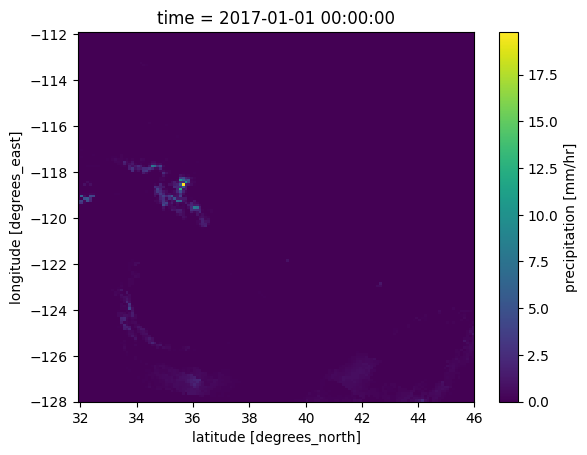

In [25]:
imerg['precipitation'][0].plot()

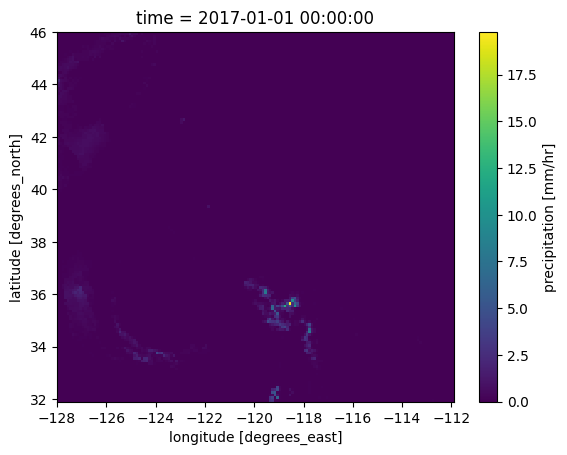

In [64]:
imerg_new['precipitation'][0].plot()

In [66]:
np.isnan(imerg_new.precipitation.values).sum()

0

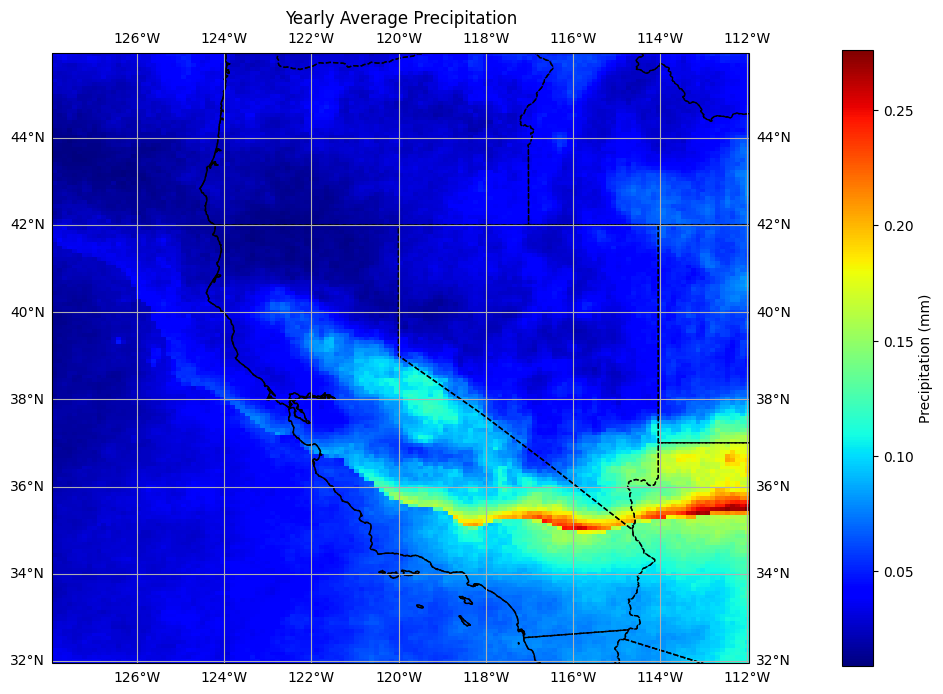

In [62]:
lons = imerg['lon'].values
lats = imerg['lat'].values
precipitation = imerg['precipitation']

# Calculate yearly average precipitation
mean_precip = imerg['precipitation'].mean(dim = 'time')

# Define extent based on your data
min_lon, max_lon = np.min(lons), np.max(lons)
min_lat, max_lat = np.min(lats), np.max(lats)

# Plotting with Cartopy
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot data
im = plt.imshow(mean_precip, extent=(min_lon, max_lon, min_lat, max_lat),
                cmap='jet', origin='lower', transform=ccrs.PlateCarree())
c_bar = plt.colorbar(im, label='Precipitation (mm)', orientation='vertical', pad=0.1)

# Add map features
ax.coastlines()
ax.gridlines(draw_labels=True)

ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='--')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Yearly Average Precipitation')

plt.show()

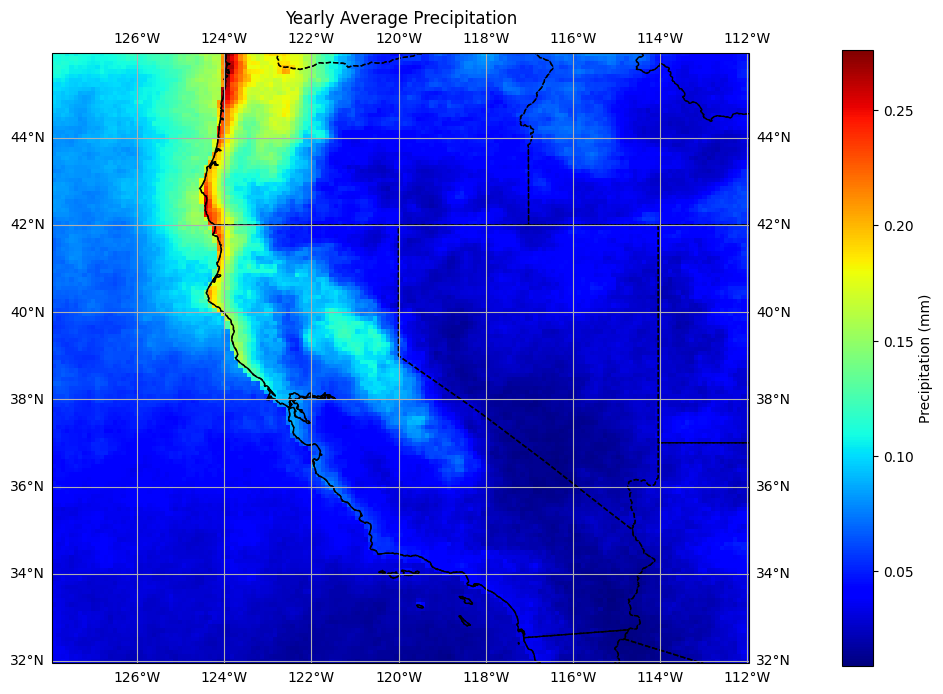

In [63]:
lons = imerg_new['lon'].values
lats = imerg_new['lat'].values
precipitation = imerg_new['precipitation']

# Calculate yearly average precipitation
mean_precip = imerg_new['precipitation'].mean(dim = 'time')

# Define extent based on your data
min_lon, max_lon = np.min(lons), np.max(lons)
min_lat, max_lat = np.min(lats), np.max(lats)

# Plotting with Cartopy
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot data
im = plt.imshow(mean_precip, extent=(min_lon, max_lon, min_lat, max_lat),
                cmap='jet', origin='lower', transform=ccrs.PlateCarree())
c_bar = plt.colorbar(im, label='Precipitation (mm)', orientation='vertical', pad=0.1)

# Add map features
ax.coastlines()
ax.gridlines(draw_labels=True)

ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='--')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Yearly Average Precipitation')

plt.show()